# 特徴量設計 (feature engineering) 2

In [54]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [55]:
import datetime
import os
import pathlib

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import talib as ta
from matplotlib import dates as mdates
from scipy.interpolate import make_smoothing_spline

from funcs.ios import get_excel_sheet
from funcs.tse import get_ticker_name_list

In [56]:
# ソースファイル
date_str = "20250819"
path_excel = f"../excel/tick_{date_str}.xlsx"
code = "7011"
name = get_ticker_name_list([code])[code]
print(code, name)
excel_file = str(pathlib.Path(path_excel).resolve())
df_tick = get_excel_sheet(excel_file, code)
df_tick.index = [
    pd.to_datetime(str(datetime.datetime.fromtimestamp(t))) for t in df_tick["Time"]
]
cols = list(df_tick.columns[~df_tick.columns.isin(["Time"])])
df_tick = df_tick[cols]
print(df_tick.head())

7011 三菱重工業
                            Price   Volume
2025-08-19 09:01:15.496406   4025  1213700
2025-08-19 09:01:17.326403   4030  1827900
2025-08-19 09:01:17.515900   4030  1827900
2025-08-19 09:01:18.532149   4030  1827900
2025-08-19 09:01:19.536610   4033  1888700


## 特徴量設計

In [57]:
price_ticker = 1 # 銘柄別呼び値
factor_ticker = 10   # 銘柄別調整因子
unit = 100  # 最小取引単位
period = 60  # 集計期間

# 株価差分
df_tick["dPrice"] = df_tick["Price"].diff() / price_ticker

# 累計出来高差分 / 最小取引単位
df_tick["dVol"] = np.log1p(df_tick["Volume"].diff() / unit) / factor_ticker

df_tick

,Price,Volume,dPrice,dVol
2025-08-19 09:01:15.496406,4025,1213700,NaN,NaN
2025-08-19 09:01:17.326403,4030,1827900,5.0,0.872307
2025-08-19 09:01:17.515900,4030,1827900,0.0,0.000000
2025-08-19 09:01:18.532149,4030,1827900,0.0,0.000000
2025-08-19 09:01:19.536610,4033,1888700,3.0,0.641182
...,...,...,...,...
2025-08-19 15:24:45.057720,3914,25362000,0.0,0.329584
2025-08-19 15:24:46.067848,3914,25362000,0.0,0.000000
2025-08-19 15:24:47.069456,3915,25368700,1.0,0.421951
2025-08-19 15:24:48.080554,3915,25368700,0.0,0.000000


## Matplotlib の設定

In [58]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 10

## プロット

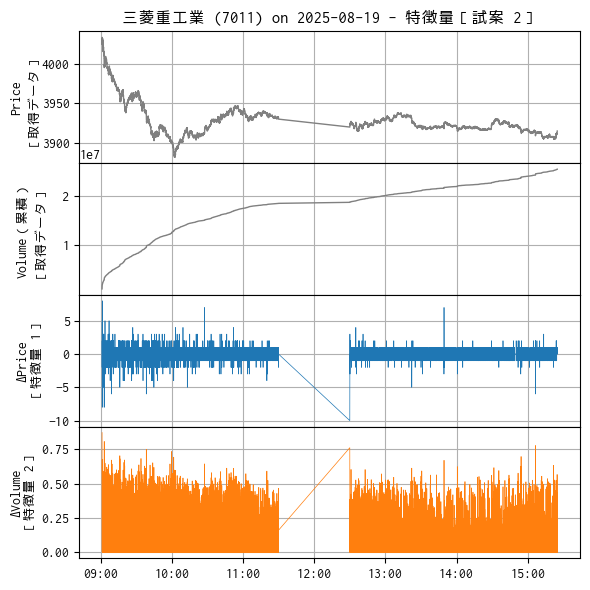

In [59]:
ax = dict()
n = 4
if n > 1:
    fig = plt.figure(figsize=(6, 2 + n))
    gs = fig.add_gridspec(
        n,
        1,
        wspace=0.0,
        hspace=0.0,
        #height_ratios=[2 if i == 0 else 1 for i in range(n)],
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid()
else:
    fig, ax[0] = plt.subplots(figsize=(6, 3))
    ax[0].grid()

# 株価
ax[0].plot(df_tick["Price"], color="gray", linewidth=1)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_ylabel("Price\n［取得データ］")
ax[0].set_title(f"{name} ({code}) on {df_tick.index[0].strftime('%Y-%m-%d')} - 特徴量［試案 2］")

# 出来高
ax[1].plot(df_tick["Volume"], color="gray", linewidth=1)
ax[1].set_ylabel("Volume（累積）\n［取得データ］\n")

# 株価差分
ax[2].plot(df_tick["dPrice"], color="C0", linewidth=0.5)
ax[2].set_ylabel("ΔPrice\n［特徴量 1］")

# 累計出来高差分対数
ax[3].plot(df_tick["dVol"], color="C1", linewidth=0.5)
ax[3].set_ylabel("ΔVolume\n［特徴量 2］")

plt.tight_layout()
plt.savefig(f"screenshots/tick_features_{code}_{date_str}_3.png")
plt.show()